#### Introduction:

<u>Prediction: </u>

Input:	best performing model, best performing dataset

Process:	

-	Filter the dataset of those unlabelled data
-	Make predictions from the model on the unlabelled data 

Quality control:	The number of prediction should match the total number of the unlabelled data

Output:	the ranked probability of positive of the unlabelled data

<u>Visualise Results:</u>

Input:	the predicted probability

Process:	Visualise data the distribution of each probability range from 0 to 1 with interval 0.05

Output:	

- distribution of the log frequency 
- cumulative distribution of the probability


#### Import Libraries

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=10)

#### Define helper functions

In [3]:
# define a function to map the predicted probability to the unlabelled genes

def map_proba(dataset, y_pred_proba, all_id=True):
    '''
    map the predicted probability to the unlabelled genes
    parameters:
        dataset: pandas dataframe, the dataset that the final model is produced
        y_pred_proba: numpy array, the predictions being make on each unlabelled data
        all_id: boolean, if the return should include all records or only the unlabbelled data
    return:
        output: pandas dataframe, the prediction results of the 
    '''
    data = dataset.copy()
    data['y_pred_proba'] = np.nan
    
    # create a boolean mask for unlabelled data rows where 'y' is 0
    unlab_data_mask = data['y'] == 0

    # ensure the length of y_pred_proba matches the number of True values in the mask
    assert len(y_pred_proba) == sum(unlab_data_mask), "Length mismatch between predictions and mask."

    # apply predictions
    data.loc[unlab_data_mask, 'y_pred_proba'] = y_pred_proba
    data = data[['id', 'y_pred_proba']]
    
    if not all_id:
        data = data.loc[unlab_data_mask]
        
    return data

#### Load the best performing model

In [4]:
final_model_path = os.path.join('final_model', 'final_model.pickle')

with open(final_model_path, 'rb') as f:
    model = pickle.load(f)

In [5]:
# if user want to load another model to do the prediction

# best_models_file_path = os.path.join(eval_models_path, 'file_name_of_the_models_set')

# with open(best_models_file_path, 'rb') as f:
#     models = pickle.load(f)

# specify the model index in the models set
# i = 2
# model = models[i]

#### Loading the dataset that would mathch the selected model (d=96, random seed = None)

In [6]:
# load the datasets that math the final model

dataset_filename = 'dataset_p_4_q_1_dim_96_walkleng_100_numwalks_500.csv'

file_path = os.path.join('data', 'datasets', dataset_filename)
dataset = pd.read_csv(file_path)

#### Make prediction on the unlabelled data

In [7]:
# make prediction to those unlabelled data, and obtain the probability of positive label for each unlabelled data

unlabelled_data = dataset.loc[dataset['y'] == 0]
X = unlabelled_data.drop(['id', 'y'], axis=1)
y = unlabelled_data['y']
y_pred_proba = model.predict_proba(X)[:,1]

In [8]:
# export the prediction to a .csv file

file_name = 'best_model_' + dataset_filename + '.csv'
prediction_file_path = os.path.join('sample_predictions', file_name)

prediction = map_proba(dataset, y_pred_proba, all_id=False)
sorted_prediction = prediction.sort_values(by='y_pred_proba', ascending=False)
sorted_prediction.to_csv(prediction_file_path, index=False, na_rep="N/A")

#### Visualise the distribution of the prediction probability

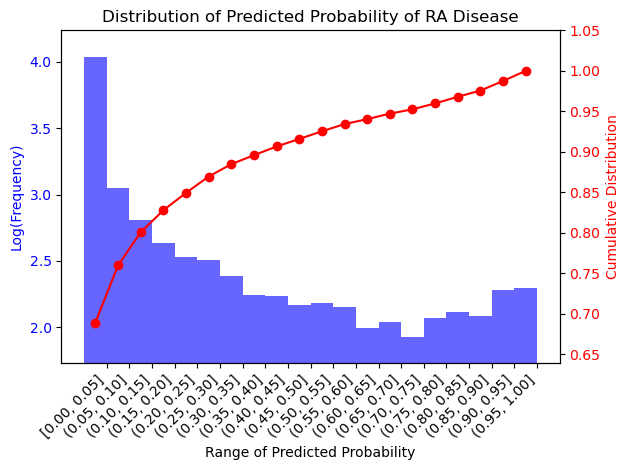

In [9]:
# Sample data
predicted_probabilities = y_pred_proba

# Bin the data
bins = np.arange(0, 1.05, 0.05)
hist, bin_edges = np.histogram(predicted_probabilities, bins=bins, density=False)

# Calculate the log (base 10) of frequency
log_hist = np.log10(hist + 1)

# Calculate adaptive y-axis limits for log histogram with a buffer
buffer = 0.2
lower_limit = np.min(log_hist) - buffer
upper_limit = np.max(log_hist) + buffer

# Calculate the cumulative distribution
cumulative_distribution = np.cumsum(hist) / len(predicted_probabilities)

# Calculate adaptive y-axis limits for the cumulative distribution with a buffer
buffer_cumulative = 0.05
lower_limit_cumulative = np.min(cumulative_distribution) - buffer_cumulative
upper_limit_cumulative = np.max(cumulative_distribution) + buffer_cumulative

# Plot
fig, ax1 = plt.subplots()

ax1.set_title('Distribution of Predicted Probability of RA Disease')

# Left y-axis settings: log of frequency
ax1.bar(bin_edges[:-1], log_hist, width=0.05, color='blue', alpha=0.6)
ax1.set_ylabel('Log(Frequency)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(lower_limit, upper_limit)

# Modify x-axis ticks to show range
xticks_loc = bins[:-1] + 0.025  # shift by half the bin width to center
xticks_labels = [f"[{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}]" if i == 0 
                 else f"({bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}]" 
                 for i in range(len(bin_edges)-1)]
ax1.set_xticks(xticks_loc)
ax1.set_xticklabels(xticks_labels, rotation=45, ha='right')
ax1.set_xlabel('Range of Predicted Probability')

# Right y-axis settings: cumulative distribution
ax2 = ax1.twinx()
ax2.plot(bin_edges[:-1], cumulative_distribution, color='red', marker='o')
ax2.set_ylabel('Cumulative Distribution', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(lower_limit_cumulative, upper_limit_cumulative)

plt.tight_layout()
plt.show()